In [1]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

In [137]:
IMAGE_SIZE=300

## Pupil Function

In [138]:
def create_angle_slit(h, w, slit_width, damp, r0=None, r1=None, flip=None):
    first_row = np.array([True]*slit_width + [False]*(w - slit_width))
    first_col = np.array([True] + [False]*(h-1))
    full_slit = toeplitz(first_col, first_row)
    
    mask = create_circular_mask(h, w, radius=(w - damp)/2)
    slit = full_slit * mask
    
    if flip:
        slit = np.flip(slit, axis=1)
    if r0:
        slit = np.roll(slit, r0, axis=0)
    if r1:
        slit = np.roll(slit, r1, axis=1)
    
    return slit

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [148]:
# References:
# https://github1s.com/greje656/PhysicallyBasedLensFlare/blob/master/Lens/starburst.hlsl
# http://kmdouglass.github.io/posts/simple-pupil-function-calculations/
def create_dirty_mask(size):
    dirty_mask = np.zeros(shape=(size, size), dtype=bool)

    num_dots = round(np.random.normal(size / 7, size / 30))
    max_dot_radius = round(np.random.normal(size / 100, size / 100))

    # add dot masks
    for i in range(num_dots):
        x = round(np.random.uniform(0, dirty_mask.shape[1]))
        y = round(np.random.uniform(0, dirty_mask.shape[0]))
        r = round(np.random.uniform(0, max_dot_radius))

        dot = create_circular_mask(size, size, radius=r, center=(x, y))
        dirty_mask += dot

    num_slits = round(np.random.normal(size / 12, size / 30))
    
    # add slit masks
    for i in range(num_slits):
        r0 = round(np.random.uniform(-size / 2, size / 2))
        r1 = round(np.random.uniform(-size / 2, size / 2))
        flip = np.random.choice([False, True])
        length = round(np.random.uniform(size / 2, size / 1.2))

        slit = create_angle_slit(size, size, 2, length, r0=r0, r1=r1, flip=flip)
        dirty_mask += slit

    return dirty_mask

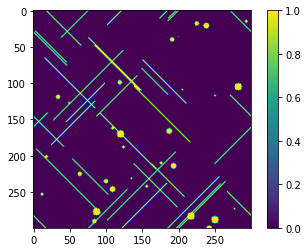

In [149]:
aperture_function = create_dirty_mask(IMAGE_SIZE)
plt.imshow(aperture_function.astype(np.uint8))
plt.colorbar()

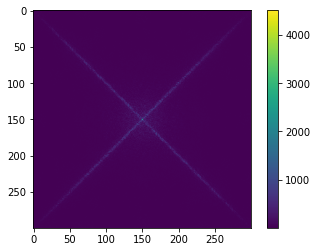

In [150]:
circle_fourier = np.abs(np.fft.fft2(aperture_function.astype(float))) ** 2
plt.imshow(np.fft.fftshift(circle_fourier) ** 0.5)
plt.colorbar()

In [15]:
origin = (200, 100)
depth = 300

def create_phase_matrix(width, lr_shift, ud_shift):
    k = np.arange(-width//2, width//2) * (1.0 / width)
    kx, ky = np.meshgrid(k, k)

    return np.exp(1j * 2 * np.pi * (kx * lr_shift + ky * ud_shift)).astype('complex')
    

class:  ndarray
shape:  (250, 250)
strides:  (4000, 16)
itemsize:  16
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f920ca6e000
byteorder:  little
byteswap:  False
type: complex128


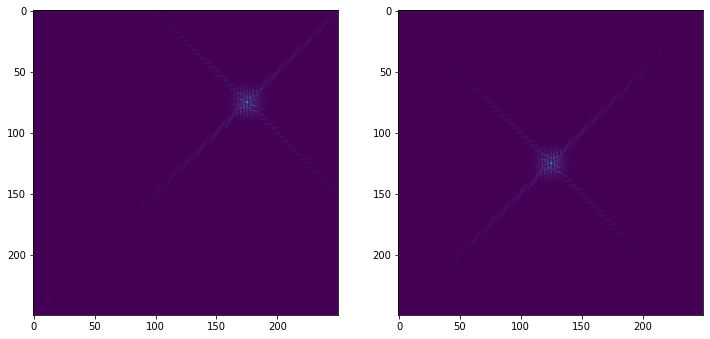

In [16]:
phase = create_phase_matrix(IMAGE_SIZE,50,-50)
pupil_func = aperture_function.astype(np.complex64) * phase

np.info(pupil_func)


t = np.abs(np.fft.fft2(pupil_func)) ** 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 24))

shifted_circle_fourier = np.fft.fftshift(circle_fourier)
shifted_t = np.fft.fftshift(t)

ax1.imshow(shifted_t)
ax2.imshow(shifted_circle_fourier)

## Spectral Response Function

In [17]:
from scipy.stats import norm

In [18]:
wavelengths = np.arange(380, 745, 5)

In [19]:
mu_R = np.random.uniform(620, 640, 1)
mu_G = np.random.uniform(540, 560, 1)
mu_B = np.random.uniform(460, 480, 1)

sigma_R = np.random.uniform(50, 60, 1)
sigma_G = np.random.uniform(50, 60, 1)
sigma_B = np.random.uniform(50, 60, 1)

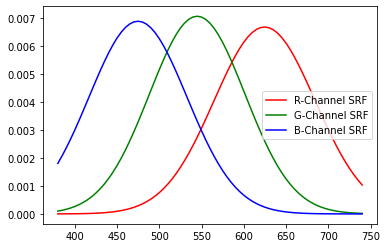

In [20]:
# Example SRF
plt.plot(wavelengths, norm.pdf(wavelengths, mu_R, sigma_R), color='r', label='R-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_G, sigma_G), color='g', label='G-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_B, sigma_B), color='b', label='B-Channel SRF')
plt.legend()

In [21]:
SRF_R = norm.pdf(wavelengths, mu_R, sigma_R)[None, :]
SRF_G = norm.pdf(wavelengths, mu_G, sigma_G)[None, :]
SRF_B = norm.pdf(wavelengths, mu_B, sigma_B)[None, :]

In [22]:
SRF = np.concatenate((SRF_R, SRF_G, SRF_B), axis=0)
SRF.shape

(3, 73)

## Combining

In [23]:
psf = np.repeat(np.expand_dims(shifted_t, axis=0), 73, axis=0)
psf = psf.reshape(73, -1)

In [24]:
psf.shape

(73, 62500)

In [25]:
psf_rgb = (SRF @ psf)

In [26]:
psf_rgb = psf_rgb.reshape(3, IMAGE_SIZE, IMAGE_SIZE)

In [27]:
psf_rgb = psf_rgb / np.max(psf_rgb)

In [28]:
psf_rgb

array([[[0.00638928, 0.02044906, 0.00125146, ..., 0.00096861,
         0.00051925, 0.02161983],
        [0.01323737, 0.00873512, 0.00166762, ..., 0.0038589 ,
         0.00690449, 0.0255232 ],
        [0.01840933, 0.00047038, 0.00021568, ..., 0.00054324,
         0.02821726, 0.00459257],
        ...,
        [0.00037909, 0.0223188 , 0.00245506, ..., 0.00022098,
         0.00271836, 0.00042438],
        [0.01098497, 0.01221317, 0.0166714 , ..., 0.00361828,
         0.00086884, 0.00134308],
        [0.0312615 , 0.00608479, 0.01610577, ..., 0.00566658,
         0.00136518, 0.00087102]],

       [[0.00653631, 0.02091963, 0.00128026, ..., 0.0009909 ,
         0.0005312 , 0.02211734],
        [0.01354198, 0.00893613, 0.00170599, ..., 0.0039477 ,
         0.00706338, 0.02611053],
        [0.01883296, 0.0004812 , 0.00022065, ..., 0.00055574,
         0.02886659, 0.00469826],
        ...,
        [0.00038781, 0.0228324 , 0.00251155, ..., 0.00022606,
         0.00278091, 0.00043414],
        [0.0

In [29]:
psf_rgb

array([[[0.00638928, 0.02044906, 0.00125146, ..., 0.00096861,
         0.00051925, 0.02161983],
        [0.01323737, 0.00873512, 0.00166762, ..., 0.0038589 ,
         0.00690449, 0.0255232 ],
        [0.01840933, 0.00047038, 0.00021568, ..., 0.00054324,
         0.02821726, 0.00459257],
        ...,
        [0.00037909, 0.0223188 , 0.00245506, ..., 0.00022098,
         0.00271836, 0.00042438],
        [0.01098497, 0.01221317, 0.0166714 , ..., 0.00361828,
         0.00086884, 0.00134308],
        [0.0312615 , 0.00608479, 0.01610577, ..., 0.00566658,
         0.00136518, 0.00087102]],

       [[0.00653631, 0.02091963, 0.00128026, ..., 0.0009909 ,
         0.0005312 , 0.02211734],
        [0.01354198, 0.00893613, 0.00170599, ..., 0.0039477 ,
         0.00706338, 0.02611053],
        [0.01883296, 0.0004812 , 0.00022065, ..., 0.00055574,
         0.02886659, 0.00469826],
        ...,
        [0.00038781, 0.0228324 , 0.00251155, ..., 0.00022606,
         0.00278091, 0.00043414],
        [0.0

In [30]:
psf_rgb.sum(axis=0)

array([[0.01916901, 0.06135094, 0.00375461, ..., 0.00290601, 0.00155786,
        0.06486346],
       [0.03971453, 0.02620698, 0.00500316, ..., 0.0115774 , 0.02071475,
        0.07657429],
       [0.05523139, 0.00141122, 0.00064709, ..., 0.00162981, 0.08465697,
        0.01377857],
       ...,
       [0.00113734, 0.06696051, 0.00736562, ..., 0.00066298, 0.00815558,
        0.00127321],
       [0.03295692, 0.03664177, 0.05001726, ..., 0.01085551, 0.00260667,
        0.0040295 ],
       [0.09379026, 0.01825549, 0.04832026, ..., 0.01700077, 0.00409579,
        0.00261323]])

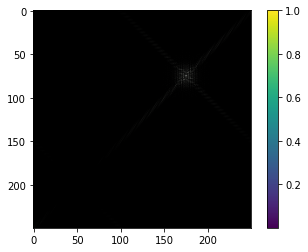

In [31]:
plt.imshow(np.transpose(psf_rgb, (1, 2, 0)))
plt.colorbar()